In [82]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [80]:
fr = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv')
fr = fr.drop(fr.filter(regex='Unnamed').columns, axis=1)  # filter out the "Unnamed: " column 
fr

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,0.536,679.05463,+,2.408421e+07,NaN,NaN,49,6939.264074,7204.617522,1.145548e+07,...,1.771940e+07,1.647246e+07,1.366983e+07,1.568381e+07,1.290439e+07,1.353820e+07,1.360893e+07,8616.499626,7755.590041,7473.385618
1,0.537,641.10870,+,5.522238e+07,NaN,NaN,36,4957.644286,5147.221739,4.677270e+07,...,3.852845e+07,4.172903e+07,6.220326e+06,4.279894e+07,3.789880e+07,3.219858e+07,2.889174e+07,5992.201567,5261.096948,5307.954232
2,0.541,951.15973,-,3.238113e+07,NaN,NaN,10,31210.491250,6708.897037,1.625939e+07,...,1.569916e+07,1.912593e+07,1.216820e+07,2.036861e+07,1.952822e+07,1.953922e+07,1.543462e+07,9861.409380,94752.403070,72744.082630
3,0.542,329.03067,-,2.882770e+08,NaN,NaN,55,35414.640900,7612.606206,1.290199e+08,...,2.882770e+08,1.142664e+08,1.452781e+08,1.763549e+08,2.236196e+08,1.790767e+08,1.651242e+08,235854.330500,107515.844600,82542.935410
4,0.544,969.13147,-,1.697296e+07,NaN,NaN,14,36157.660320,7772.323038,1.089197e+07,...,6.578465e+06,8.023917e+06,4.351532e+06,1.132409e+07,1.040661e+07,8.373267e+06,9.059848e+06,240802.689200,109771.588600,84274.733400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,3.296976e+06,NaN,NaN,19,13463.679470,14827.939600,1.801313e+06,...,2.390561e+05,1.291650e+06,2.886770e+05,8.545798e+05,6.331233e+05,1.647502e+06,2.088592e+05,15946.120300,15354.653040,15239.583030
1483,20.196,871.80945,+,2.595829e+06,NaN,NaN,6,11170.753640,11883.403090,1.053780e+06,...,7.948007e+04,8.523295e+05,8.869149e+04,4.884374e+05,1.233201e+05,1.052764e+06,4.261791e+04,12779.535150,11523.481420,11266.124030
1484,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,12695.823470,13819.097200,5.844701e+05,...,3.421911e+05,3.890957e+05,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05,23229.657890,14761.180040,17844.172830
1485,20.452,1164.01404,+,3.204960e+06,NaN,NaN,2,13749.188890,14296.409340,1.669550e+04,...,2.521927e+05,2.039074e+04,7.236153e+05,3.054687e+04,1.097559e+06,2.851977e+04,5.293939e+05,24032.011160,15271.031760,18460.511230


### Basic feature engineering:

1. Remove blank and water samples (5 total)

2. Separate into control vs test groups

3. Create 2nd pandas table of metadata compiled from Huishi's metadata info spreadsheet:
    1. "20210421_FBGRBGOGTT_Huishi sample sheet.xlsx"
    2. Include timepoints in pd.datetime format
    3. Include each rat's phenotypes (glucose level, insulin, weight, age, etc.) 
    
4. Explanation of sample metadata:
    1. Rat names: "T1060M", "T1061M", ... "T1102M" (not all number
        1. Not all numbers between 1060 and 1102 are included.
        2. NB: Not all rats had samples submitted for MS lipidomics
        
    2. RBG vs FBG 
        1. RBG = random blood glucose (randomly sampled blood glucose levels)
        2. FBG = fasted blood glucose (collected after fasting at pre-determined time intervals)
        
    3. Age
        1. Date of birth, between 1/23/2021 and 2/1/2021
        2. Metadata from Huishi organized based on "X weeks old" 
            1. Time points: 4, 8, 9, 10, 11, 12 weeks old 
            
     4. Weight
         1. Weights given as around 100, I assume this is grams
         2. Also gives "Weight gain %" or "Weight loss %"
         3. Also includes "Weight (pre-fasting)"
         3. Also includes "4 to 8 weeks" "Weight gain %"
         5. One of the weights has a note "euthanized due to tail injury" and blanks for that rat thereafter
            
     5. Date and time
         1. Given in "When" column
         2. Formats given as "3/26 6pm" or "4/10 10:30am" or "03/29 10:30am" 
      
    10. Other metadata:
        1. Note at top of metadata spreadsheet: "Fasting from 6:30pm to 10:30am; Light cycle 10am to 10pm"
            1. Referring to fasting periods for nile rats, and when the lights were on/off in the room
        2. "Collected hypothalamus, interscapular white fat, interscapular brown fat, inguinal white fat, mesenteric visceral white rat, pancreas, duodenum, jejunum, ileum, liver,"
        3. "Isoflurane 3% with 2L/min oxygen (~2min to go under)"
        4. Under the post-mortem phenotypes: "Used pre-fasting weight to calculate amount of dextrose"


In [251]:
sample_order = pd.read_csv(r'..\data\metadata\20210729_AJ_Toh_RatPlasma_Sequence_Exported.csv', skiprows=1)
sample_order['order'] = range(1, 68)
sample_order = sample_order[['File Name', 'order']]
sample_order

,File Name,order
0,20210729_AJ_Toh_RatBloodGlucose_Water_R1,1
1,20210729_AJ_Toh_RatBloodGlucose_Water_R2,2
2,20210729_AJ_Toh_RatBloodGlucose_Water_R3,3
3,20210729_AJ_Toh_RatBloodGlucose_SolventBlank,4
4,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank,5
...,...,...
62,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021040...,63
63,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021033...,64
64,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021033...,65
65,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021041...,66


In [257]:
## T1062M_20210329_9wk_FBG Is sampled 3 times, each with a QC label.
## The 1st QC has low quants and we could ignore.
## The 2nd and 3rd QC appear OK, so use the QC2 as the one to include in all samples
## There is no non-QC file for T1062M_20210329_9wk_FBG

qc1qc3 = fr.filter(regex='QC1|QC3')

In [245]:
blanks.shape

(1487, 5)

In [23]:
blanks = fr.filter(regex='Blank|Water')
blanks

,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,6939.264074,7204.617522,8616.499626,7755.590041,7473.385618
1,4957.644286,5147.221739,5992.201567,5261.096948,5307.954232
2,31210.491250,6708.897037,9861.409380,94752.403070,72744.082630
3,35414.640900,7612.606206,235854.330500,107515.844600,82542.935410
4,36157.660320,7772.323038,240802.689200,109771.588600,84274.733400
...,...,...,...,...,...
1482,13463.679470,14827.939600,15946.120300,15354.653040,15239.583030
1483,11170.753640,11883.403090,12779.535150,11523.481420,11266.124030
1484,12695.823470,13819.097200,23229.657890,14761.180040,17844.172830
1485,13749.188890,14296.409340,24032.011160,15271.031760,18460.511230


In [272]:
blanks.columns

array(['20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1)',
       '20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2)',
       '20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65)',
       '20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66)',
       '20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)'], dtype=object)

In [270]:
fr

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,0.536,679.05463,+,2.408421e+07,NaN,NaN,49,6939.264074,7204.617522,1.145548e+07,...,1.771940e+07,1.647246e+07,1.366983e+07,1.568381e+07,1.290439e+07,1.353820e+07,1.360893e+07,8616.499626,7755.590041,7473.385618
1,0.537,641.10870,+,5.522238e+07,NaN,NaN,36,4957.644286,5147.221739,4.677270e+07,...,3.852845e+07,4.172903e+07,6.220326e+06,4.279894e+07,3.789880e+07,3.219858e+07,2.889174e+07,5992.201567,5261.096948,5307.954232
2,0.541,951.15973,-,3.238113e+07,NaN,NaN,10,31210.491250,6708.897037,1.625939e+07,...,1.569916e+07,1.912593e+07,1.216820e+07,2.036861e+07,1.952822e+07,1.953922e+07,1.543462e+07,9861.409380,94752.403070,72744.082630
3,0.542,329.03067,-,2.882770e+08,NaN,NaN,55,35414.640900,7612.606206,1.290199e+08,...,2.882770e+08,1.142664e+08,1.452781e+08,1.763549e+08,2.236196e+08,1.790767e+08,1.651242e+08,235854.330500,107515.844600,82542.935410
4,0.544,969.13147,-,1.697296e+07,NaN,NaN,14,36157.660320,7772.323038,1.089197e+07,...,6.578465e+06,8.023917e+06,4.351532e+06,1.132409e+07,1.040661e+07,8.373267e+06,9.059848e+06,240802.689200,109771.588600,84274.733400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,3.296976e+06,NaN,NaN,19,13463.679470,14827.939600,1.801313e+06,...,2.390561e+05,1.291650e+06,2.886770e+05,8.545798e+05,6.331233e+05,1.647502e+06,2.088592e+05,15946.120300,15354.653040,15239.583030
1483,20.196,871.80945,+,2.595829e+06,NaN,NaN,6,11170.753640,11883.403090,1.053780e+06,...,7.948007e+04,8.523295e+05,8.869149e+04,4.884374e+05,1.233201e+05,1.052764e+06,4.261791e+04,12779.535150,11523.481420,11266.124030
1484,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,12695.823470,13819.097200,5.844701e+05,...,3.421911e+05,3.890957e+05,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05,23229.657890,14761.180040,17844.172830
1485,20.452,1164.01404,+,3.204960e+06,NaN,NaN,2,13749.188890,14296.409340,1.669550e+04,...,2.521927e+05,2.039074e+04,7.236153e+05,3.054687e+04,1.097559e+06,2.851977e+04,5.293939e+05,24032.011160,15271.031760,18460.511230


In [286]:
# To get all 60 samples, filter out files with Blank, Water, QC1 or QC3 in it (we retain QC2 as a sample)
# Then filter by columns with .raw in it, to drop the other columns in Lipidex FR 

samples_with_ld_quant = fr.drop(list(fr.filter(regex='Blank|Water|QC1|QC3').columns), axis=1)
print(samples_with_ld_quant['Features Found'].value_counts())
samples = samples_with_ld_quant.filter(regex='.raw')


2      233
3      118
4       73
62      58
6       47
      ... 
79       1
76       1
75       1
70       1
165      1
Name: Features Found, Length: 113, dtype: int64


In [234]:
fbg = fr.filter(regex='FBG')
fbg.columns  ## Beware that QCs are still in this

Index(['20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3)',
       '20210729_AJ_Toh_RatBloodGlucose_T1060M_20210329_9wk_FBG.raw (F5)',
       '20210729_AJ_Toh_RatBloodGlucose_T1060M_20210405_10wk_FBG.raw (F7)',
       '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9)',
       '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11)',
       '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC2.raw (F12)',
       '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC3.raw (F13)',
       '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210405_10wk_FBG.raw (F15)',
       '20210729_AJ_Toh_RatBloodGlucose_T1074M_20210322_8wk_FBG.raw (F17)',
       '20210729_AJ_Toh_RatBloodGlucose_T1074M_20210329_9wk_FBG.raw (F19)',
       '20210729_AJ_Toh_RatBloodGlucose_T1074M_20210405_10wk_FBG.raw (F21)',
       '20210729_AJ_Toh_RatBloodGlucose_T1076M_20210322_8wk_FBG.raw (F23)',
       '20210729_AJ_Toh_RatBloodGlucose_T1076M_20210329_9wk_FBG.raw (F25)',
 

In [26]:
rbg = fr.filter(regex='RBG')
rbg

,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210408_10wk_RBG.raw (F8),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG.raw (F10),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG.raw (F14),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210408_10wk_RBG.raw (F16),20210729_AJ_Toh_RatBloodGlucose_T1074M_20210325_8wk_RBG.raw (F18),20210729_AJ_Toh_RatBloodGlucose_T1074M_20210401_9wk_RBG.raw (F20),20210729_AJ_Toh_RatBloodGlucose_T1074M_20210408_10wk_RBG.raw (F22),20210729_AJ_Toh_RatBloodGlucose_T1076M_20210325_8wk_RBG.raw (F24),...,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210413_10wk_RBG.raw (F46),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210330_8wk_RBG.raw (F48),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210406_9wk_RBG.raw (F50),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210330_8wk_RBG.raw (F54),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210406_9wk_RBG.raw (F56),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64)
0,1.728814e+07,2.381849e+07,1.222901e+07,7.822806e+06,1.580575e+07,1.536694e+07,1.887773e+07,2.008174e+07,1.659649e+07,1.388434e+07,...,1.948473e+07,1.008028e+07,2.264905e+07,1.614774e+07,1.802184e+07,1.258442e+07,1.771940e+07,1.366983e+07,1.290439e+07,1.360893e+07
1,5.522238e+07,3.699951e+07,3.143719e+07,1.570121e+07,8.711962e+06,3.440920e+07,3.749083e+07,5.007386e+07,3.552814e+07,2.819442e+07,...,3.850314e+07,2.125427e+07,4.305924e+07,3.011081e+07,3.746665e+07,3.415574e+07,3.852845e+07,6.220326e+06,3.789880e+07,2.889174e+07
2,3.238113e+07,9.969525e+06,2.428798e+07,1.428936e+07,2.507414e+07,1.797342e+07,1.375754e+07,2.872933e+07,2.320817e+07,3.204844e+07,...,1.736865e+07,2.449194e+07,2.307746e+07,1.352241e+07,2.325097e+07,1.658884e+07,1.569916e+07,1.216820e+07,1.952822e+07,1.543462e+07
3,6.760284e+07,2.170599e+08,2.321839e+08,1.913929e+08,2.456139e+08,2.014200e+08,2.258963e+08,2.120171e+08,2.030766e+08,1.926305e+08,...,1.492937e+08,1.129640e+08,2.029584e+08,1.880087e+08,2.077820e+08,2.173414e+08,2.882770e+08,1.452781e+08,2.236196e+08,1.651242e+08
4,1.697296e+07,5.828327e+06,1.110572e+07,6.922304e+06,1.370329e+07,9.840100e+06,1.183950e+07,1.254660e+07,1.027590e+07,1.157832e+07,...,6.381819e+06,6.923498e+06,1.191793e+07,7.580783e+06,1.093466e+07,9.879815e+06,6.578465e+06,4.351532e+06,1.040661e+07,9.059848e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,1.867413e+05,2.249304e+05,1.673797e+05,6.014441e+05,3.012837e+05,2.180249e+05,2.455910e+05,1.320030e+05,3.589483e+05,1.277318e+06,...,1.414490e+05,1.866279e+05,2.881528e+05,3.294683e+05,2.568056e+05,3.804952e+05,2.390561e+05,2.886770e+05,6.331233e+05,2.088592e+05
1483,7.649254e+04,9.603305e+04,4.768530e+04,1.172183e+05,7.378381e+04,5.086314e+04,5.859577e+04,2.121847e+04,8.987062e+04,2.993580e+05,...,2.046397e+04,6.176679e+04,6.828447e+04,1.025987e+05,7.634704e+04,1.446089e+05,7.948007e+04,8.869149e+04,1.233201e+05,4.261791e+04
1484,2.637219e+05,3.785893e+05,2.973711e+05,8.610503e+05,5.009631e+05,2.777700e+05,3.184925e+05,2.830243e+05,4.342125e+05,2.011681e+06,...,2.360341e+05,3.014609e+05,4.255646e+05,2.503579e+05,6.491271e+04,6.374218e+05,3.421911e+05,7.912981e+05,1.147269e+06,5.509051e+05
1485,2.006306e+05,2.022126e+05,9.491840e+04,7.842521e+05,4.241803e+05,1.714623e+05,1.694512e+05,2.588987e+05,3.227181e+05,1.329877e+06,...,4.412190e+04,1.367275e+05,2.249946e+05,8.943085e+04,1.341262e+05,6.755785e+05,2.521927e+05,7.236153e+05,1.097559e+06,5.293939e+05


In [45]:
## Which animals were used in the experiment? 
## Because not all animals in the metadata had samples submitted for plasma lipidomics

cols = fr.columns

animal_numbers = []

for col in cols:
#     print(col)
    search = re.search(r"(?<=ose\_T)(.*)(?=M_)", str(col))
    if search:
#         print(search.groups()[0])
        animal_numbers.append(search.groups()[0])
    
animals_used = list(set(animal_numbers))
print(animals_used)

['1101', '1092', '1062', '1082', '1102', '1091', '1076', '1060', '1074', '1093']


In [75]:
# obs is the dataframe of observations collected by collaborators. 
# data were originally in a pivoted format, so observations were cleaned into "tidy data format"

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs.head()

,animal,when,BG,weight,weight change %,BG type,weight type,weight change type,weeks old note,note
0,T1060M,2/20 3pm,71.0,53.7,NaN,RBG,Weight,change,4 weeks old,NaN
1,T1061M,2/20 3pm,73.0,52.1,NaN,RBG,Weight,change,4 weeks old,NaN
2,T1062M,2/20 3pm,78.0,51.3,NaN,RBG,Weight,change,4 weeks old,NaN
3,T1063M,2/20 3pm,73.0,49.6,NaN,RBG,Weight,change,4 weeks old,NaN
4,T1074M,2/20 3pm,70.0,55.8,NaN,RBG,Weight,change,4 weeks old,NaN


In [79]:
# derive datetime column from 'when' column
# dateutil pandas library makes it stupidly easy to parse, it guessed right the first time 

obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
display(obs['datetime'].to_list())



[Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-20 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-02-28 15:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-21 18:00:00'),
 Timestamp('2021-03-

### MS data quality first passes 

### 1a. Feature quant boxplots per QC

Text(0.5, 1.0, 'Quality Control Samples\nFeature Quantitations')

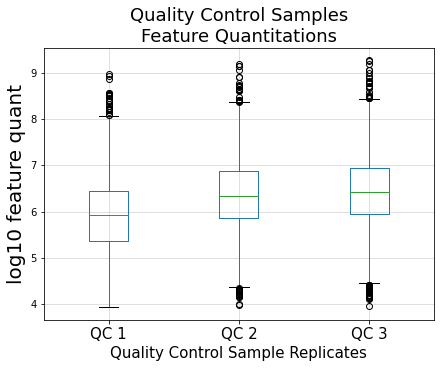

In [233]:
np.log10(fr.filter(regex='QC')).boxplot()
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches((7, 5))
ax.grid(True, alpha=0.5)
plt.xticks([1, 2, 3], labels=['QC 1', 'QC 2', 'QC 3'], fontsize=15)
plt.xlabel('Quality Control Sample Replicates', fontsize=15)
plt.ylabel('log10 feature quant', fontsize=20)
plt.title('Quality Control Samples\nFeature Quantitations', fontsize=18)


### 1b. Feature quant boxplots across samples 

In [305]:
sample_order

,File Name,order
0,20210729_AJ_Toh_RatBloodGlucose_Water_R1,1
1,20210729_AJ_Toh_RatBloodGlucose_Water_R2,2
2,20210729_AJ_Toh_RatBloodGlucose_Water_R3,3
3,20210729_AJ_Toh_RatBloodGlucose_SolventBlank,4
4,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank,5
...,...,...
62,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021040...,63
63,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021033...,64
64,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021033...,65
65,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021041...,66


In [400]:
# Re-order columns in samples df into analytical order

rawfile_cols = fr.filter(regex='.raw').columns
sample_order

sample_name_to_file_name_map = {}

for file in rawfile_cols.to_list():
    for sfile in sample_order['File Name'].to_list():
        if sfile in file:
            sample_name_to_file_name_map[sfile] = file

sample_order['sample name'] = sample_order['File Name'].apply(lambda name: sample_name_to_file_name_map[name] )

In [401]:
# increase how many chars gets printed pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', None)

# Get only the data files (minus blanks and QC1 and QC3)
analysis_file_indices = list(range(6, 66))
analysis_files = sample_order.iloc[analysis_file_indices]
analysis_files.loc[:, 'order'] = range(0, 60)
analysis_files

# Re-order the columns using .reindex()
samples = samples.reindex(columns=analysis_files['sample name'])
samples

C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


sample name,20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),20210729_AJ_Toh_RatBloodGlucose_T1091M_20210410_10wk_FBG.raw (F39),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52),20210729_AJ_Toh_RatBloodGlucose_T1082M_20210405_10wk_FBG.raw (F33),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),...,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210410_10wk_FBG.raw (F45),20210729_AJ_Toh_RatBloodGlucose_T1082M_20210325_8wk_RBG.raw (F30),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG.raw (F10),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210330_8wk_RBG.raw (F48),20210729_AJ_Toh_RatBloodGlucose_T1074M_20210329_9wk_FBG.raw (F19),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG.raw (F14),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210330_8wk_RBG.raw (F54),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210330_8wk_RBG.raw (F42),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210413_10wk_RBG.raw (F46)
0,1.388749e+06,1.049443e+07,9.897531e+06,1.728814e+07,2.129622e+07,1.623684e+07,1.614774e+07,1.152504e+07,2.381849e+07,1.231938e+07,...,8.071878e+06,1.535775e+07,7.822806e+06,1.353820e+07,1.008028e+07,6.530743e+06,1.580575e+07,1.802184e+07,2.296365e+07,1.948473e+07
1,3.035806e+06,2.537288e+07,2.207764e+07,5.522238e+07,4.634647e+07,3.333306e+07,3.011081e+07,2.861964e+07,3.699951e+07,3.428703e+07,...,3.836634e+07,1.953250e+07,1.570121e+07,3.219858e+07,2.125427e+07,7.173091e+06,8.711962e+06,3.746665e+07,4.541242e+07,3.850314e+07
2,1.663567e+06,1.402438e+07,8.735853e+06,3.238113e+07,1.778254e+07,1.947128e+07,1.352241e+07,1.872223e+07,9.969525e+06,1.802672e+07,...,1.627452e+07,8.646979e+06,1.428936e+07,1.953922e+07,2.449194e+07,1.777209e+07,2.507414e+07,2.325097e+07,2.666666e+07,1.736865e+07
3,2.215194e+07,1.187355e+08,1.114405e+08,6.760284e+07,1.723259e+08,1.765802e+08,1.880087e+08,1.666531e+08,2.170599e+08,1.575765e+08,...,2.328511e+08,1.143244e+08,1.913929e+08,1.790767e+08,1.129640e+08,1.615572e+08,2.456139e+08,2.077820e+08,2.422656e+08,1.492937e+08
4,6.816564e+05,6.906003e+06,3.505334e+06,1.697296e+07,5.381199e+06,9.870417e+06,7.580783e+06,8.089105e+06,5.828327e+06,7.257362e+06,...,8.912733e+06,5.477882e+06,6.922304e+06,8.373267e+06,6.923498e+06,7.109026e+06,1.370329e+07,1.093466e+07,5.136129e+06,6.381819e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,2.165170e+05,6.228681e+05,2.862648e+06,1.867413e+05,1.071320e+06,1.754275e+05,3.294683e+05,7.764236e+05,2.249304e+05,7.956023e+05,...,6.105715e+05,5.632101e+05,6.014441e+05,1.647502e+06,1.866279e+05,6.785598e+05,3.012837e+05,2.568056e+05,1.725933e+05,1.414490e+05
1483,3.460561e+05,3.955002e+05,2.077054e+06,7.649254e+04,9.205989e+05,4.931699e+04,1.025987e+05,7.099401e+05,9.603305e+04,4.949319e+05,...,3.747838e+05,1.769299e+05,1.172183e+05,1.052764e+06,6.176679e+04,3.332091e+05,7.378381e+04,7.634704e+04,2.534147e+04,2.046397e+04
1484,1.032091e+05,8.184697e+04,6.709454e+05,2.637219e+05,1.714771e+05,2.014974e+05,2.503579e+05,1.516585e+04,3.785893e+05,2.294775e+05,...,7.248897e+04,9.538754e+05,8.610503e+05,4.434897e+05,3.014609e+05,9.522722e+04,5.009631e+05,6.491271e+04,3.071346e+05,2.360341e+05
1485,1.414221e+04,1.504719e+04,1.625504e+04,2.006306e+05,1.544546e+04,8.294957e+04,8.943085e+04,1.568968e+04,2.022126e+05,1.547788e+04,...,1.627588e+04,7.383503e+05,7.842521e+05,2.851977e+04,1.367275e+05,1.577191e+04,4.241803e+05,1.341262e+05,2.124229e+05,4.412190e+04


['F27', 'F9', 'F49', 'F4', 'F39', 'F44', 'F52', 'F33', 'F6', 'F55', 'F16', 'F36', 'F21', 'F58', 'F25', 'F43', 'F17', 'F40', 'F31', 'F24', 'F3', 'F50', 'F7', 'F34', 'F20', 'F38', 'F57', 'F47', 'F18', 'F64', 'F12', 'F26', 'F41', 'F15', 'F60', 'F22', 'F5', 'F32', 'F28', 'F37', 'F61', 'F62', 'F51', 'F53', 'F59', 'F29', 'F8', 'F23', 'F56', 'F35', 'F45', 'F30', 'F10', 'F63', 'F48', 'F19', 'F14', 'F54', 'F42', 'F46']


Text(0.5, 1.0, 'All Samples\nFeature Quantitations')

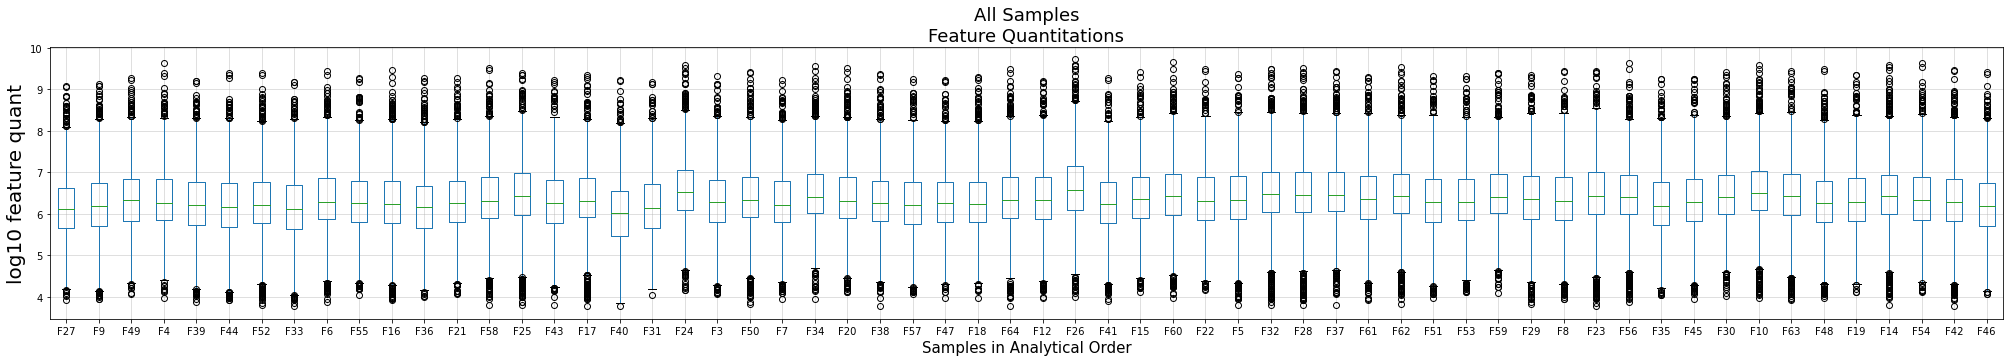

In [398]:
np.log10(samples).boxplot()
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches((35, 5))
ax.grid(True, alpha=0.5)
labels = [re.search(r'\((.*?)\)', col_name).group(1) for col_name in samples.columns.to_list()]
plt.xticks(range(1, 61), labels=labels)
# plt.xticks(range(1, 61), labels=samples.columns.to_list(), fontsize=15, rotation=90)
plt.xlabel('Samples in Analytical Order', fontsize=15)
plt.ylabel('log10 feature quant', fontsize=20)
plt.title('All Samples\nFeature Quantitations', fontsize=18)

### 2. PCA groupings by RBG vs FBG

scikitlearn's PCA needs the thing you're trying to separate on in rows, therefore take the Transpose of fr

In [173]:
tp = fr.filter(regex='FBG|RBG').T

# populate label column based on whether RBG or FBG in sample name
# lambda general form: lambda <arguments> : <Return Value if cond. True> if <condition> else <Return Value if cond. False>

tp['label'] = tp.index.map(lambda index: 'RBG' if 'RBG' in index else 'FBG')  # df.index.apply doesn't work, have to use df.index.map
tp['label'].value_counts()

FBG    32
RBG    30
Name: label, dtype: int64

In [159]:
tp.drop('label', axis=1)

,0,1,2,3,4,5,6,7,8,9,...,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),11455478.21,4.677270e+07,1.625939e+07,1.290199e+08,1.089197e+07,1.933989e+08,2.044391e+09,3.911514e+05,6825096.787,1.069831e+08,...,1.973982e+04,4.403142e+04,1.009094e+06,1.695971e+06,6.585959e+05,1.801313e+06,1.053780e+06,5.844701e+05,1.669550e+04,417229.26520
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),17288137.24,5.522238e+07,3.238113e+07,6.760284e+07,1.697296e+07,1.685820e+08,4.234264e+09,4.231877e+05,5076570.353,1.380264e+08,...,1.466687e+05,3.220979e+05,3.590850e+05,2.521954e+05,3.591638e+05,1.867413e+05,7.649254e+04,2.637219e+05,2.006306e+05,193514.46240
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210329_9wk_FBG.raw (F5),16208909.58,4.636132e+07,2.424065e+07,2.097893e+08,1.411260e+07,1.976960e+08,2.277230e+09,5.282407e+05,6153003.856,1.163225e+08,...,2.411630e+04,1.009604e+05,1.478886e+06,2.084620e+06,6.962952e+05,2.262484e+06,1.532065e+06,4.822433e+05,6.497595e+04,318233.82480
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),23818488.87,3.699951e+07,9.969525e+06,2.170599e+08,5.828327e+06,7.780203e+07,9.474041e+08,3.177282e+05,7656925.299,5.256910e+07,...,1.998136e+05,3.894164e+05,5.292559e+05,3.282916e+05,4.957885e+05,2.249304e+05,9.603305e+04,3.785893e+05,2.022126e+05,221887.32220
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210405_10wk_FBG.raw (F7),13962650.02,2.186571e+07,1.224058e+07,1.517546e+08,7.216628e+06,7.340653e+07,8.894795e+08,2.945614e+05,5584366.714,4.536340e+07,...,1.907383e+04,3.963030e+04,2.809178e+05,8.838342e+05,2.268937e+05,1.017417e+06,7.220460e+05,1.172392e+05,1.566261e+04,15523.74443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),13669828.58,6.220326e+06,1.216820e+07,1.452781e+08,4.351532e+06,7.533023e+07,7.743619e+08,1.594324e+07,4708918.598,4.280857e+07,...,7.935971e+05,1.279819e+06,9.257888e+05,3.385893e+05,5.605229e+05,2.886770e+05,8.869149e+04,7.912981e+05,7.236153e+05,426736.06820
20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),15683805.67,4.279894e+07,2.036861e+07,1.763549e+08,1.132409e+07,1.192369e+08,1.570889e+09,3.727985e+07,5175083.265,8.105388e+07,...,2.231742e+04,6.425394e+04,3.738636e+05,7.568640e+05,3.046913e+05,8.545798e+05,4.884374e+05,1.910285e+05,3.054687e+04,128210.85810
20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),12904388.90,3.789880e+07,1.952822e+07,2.236196e+08,1.040661e+07,1.640389e+08,1.597642e+09,4.025014e+07,6499974.382,9.648661e+07,...,1.076375e+06,1.653945e+06,1.557582e+06,7.641324e+05,1.110650e+06,6.331233e+05,1.233201e+05,1.147269e+06,1.097559e+06,656557.54440
20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),13538198.09,3.219858e+07,1.953922e+07,1.790767e+08,8.373267e+06,1.511862e+08,1.722987e+09,3.020021e+07,5454893.748,1.049486e+08,...,2.075910e+04,7.318210e+04,6.906385e+05,1.537818e+06,5.464527e+05,1.647502e+06,1.052764e+06,4.434897e+05,2.851977e+04,261329.13570


In [167]:
pca = PCA(n_components=2)

scaled = StandardScaler().fit_transform(tp.drop('label', axis=1))
print(scaled)
fitted = pca.fit_transform(scaled)
fitted = pd.DataFrame(fitted, columns=['pc1','pc2'])

merged = pd.concat([fitted, tp.reset_index()['label']], axis=1)
# merged

[[-0.68278079  1.18671914 -0.31108104 ...  0.19836048 -0.49902659
   0.32463299]
 [ 0.56531877  1.86829916  2.08615168 ... -0.36106358 -0.17224338
  -0.27407071]
 [ 0.3343806   1.15353556  0.8756979  ...  0.02006453 -0.41325044
   0.05970221]
 ...
 [-0.37273613  0.47092006  0.17498025 ...  1.17995043  1.42125937
   0.96512133]
 [-0.23711069  0.01112022  0.1766149  ... -0.04752662 -0.47801932
  -0.09258564]
 [-0.22197502 -0.25562094 -0.433721   ...  0.13981912  0.41184503
   0.11301955]]


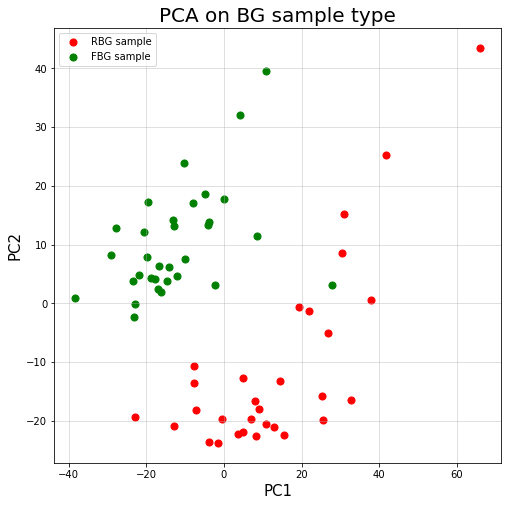

In [172]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA on BG sample type', fontsize = 20)
targets = ['RBG', 'FBG']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = merged['label'] == target
    ax.scatter(merged.loc[indicesToKeep, 'pc1'],
               merged.loc[indicesToKeep, 'pc2'],
               c = color,
               s = 50)
ax.legend(['RBG sample', 'FBG sample'])
ax.grid(alpha=0.5)

     principal component 1  principal component 2
0                -2.684207               0.326607
1                -2.715391              -0.169557
2                -2.889820              -0.137346
3                -2.746437              -0.311124
4                -2.728593               0.333925
..                     ...                    ...
145               1.944017               0.187415
146               1.525664              -0.375021
147               1.764046               0.078519
148               1.901629               0.115877
149               1.389666              -0.282887

[150 rows x 2 columns]


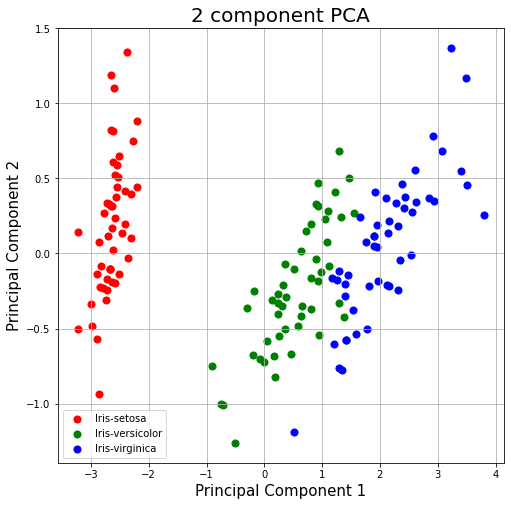

In [119]:
# from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

from sklearn.preprocessing import StandardScaler

# lengths and widths are floats, target="Iris-setosa" or "virginica" or "versicolor"

features = ['sepal length', 'sepal width', 'petal length', 'petal width']# Separating out the features
x = df.loc[:, features].values# Separating data from the target flower type
y = df.loc[:,['target']].values# Standardizing the features
# print(x)
# print(y)

# StandardScaler turns it into mean=0, variance=1 (this is sensitive to outliers though, no?)
x = StandardScaler().fit_transform(x)
# print(x)
from sklearn.decomposition import PCA

# Instantiate a pca object with 2 components
pca = PCA(n_components=2)

# populate the PCA by fit_transform the standardized data
# fit_transform returns a 2-D array with dim (n_components columns x # of Rows)
principalComponents = pca.fit_transform(x)
# print(principalComponents)

# make new df 
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Basically, you could have done the sklearn fitting directly on the pandas DF with appropriate cols
# https://stackoverflow.com/questions/23282130/principal-components-analysis-using-pandas-dataframe
finalDf = pd.concat([principalDf, df['target']], axis = 1)

better_df = pd.DataFrame(pca.fit_transform(df[features]), columns=['principal component 1', 'principal component 2'])
print((better_df))
better_final = pd.concat([better_df, df['target']], axis=1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = better_final['target'] == target
    ax.scatter(better_final.loc[indicesToKeep, 'principal component 1']
               , better_final.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()